# Github Link

The code for this project can be found at: https://github.com/zach-lloyd/colorado_supervised_machine_learning_final_project

# Exploring the Data and Refining the Problem

As I mentioned at the end of my data cleaning notebook, eyeballing my data leads me to think there are two potential issues:

1. Certain stats tend to be sparse for certain positions. For example, quarterbacks generally don't catch passes, so most QBs in my dataset don't have much in the way of receiving stats. Similarly, running backs and wide receivers have very few passing stats.
   
2. ADP data only stretches back to 2012 and Scouting Combine data only goes back to 1987. So if I want to include all passing, rushing, and receiving stats from 1932 onward, I will have 55 years without Scouting Combine data and 80 years without ADP data.

To confirm this, I wrote some code to produce a few histograms of the relevant features.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid')

df = pd.read_csv('combine_data/leviathan_plus_combine.csv')
# Replace NaNs in numeric columns with 0's. This is necessary 
# for this step because I want to be able to visualize how much data is
# missing. If I leave them as NaNs, they will just be ignored for purposes 
# of the histogram.
num_cols = df.select_dtypes('number').columns          
df[num_cols] = df[num_cols].fillna(0) 
# I replaced '40Yard' with the applicable names of the other features to
# produce the other histograms.
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='40Yard', bins=50, kde=True, ax=ax)
ax.set_title('Distribution of 40 Yard Dash Times')
plt.show()

As noted above, for the purposes of this analysis I replaced NaN values with 0's so that missing data would not be ignored by my histogram plots and I would be able to visualize what is missing. This produced the following histograms:

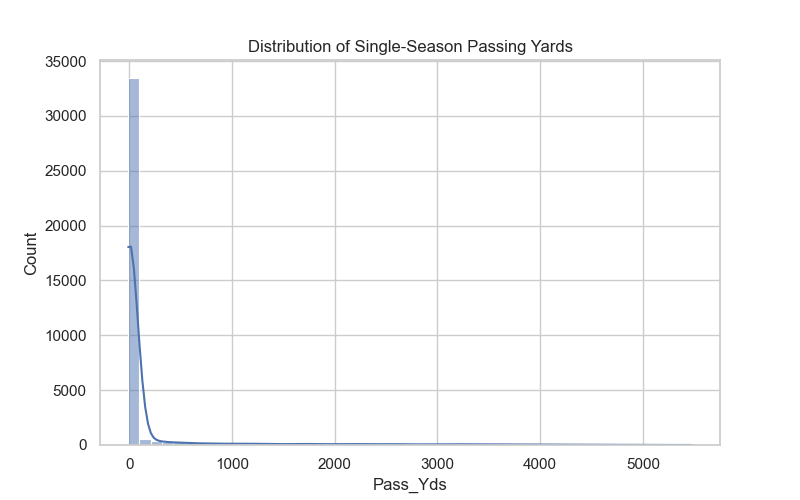

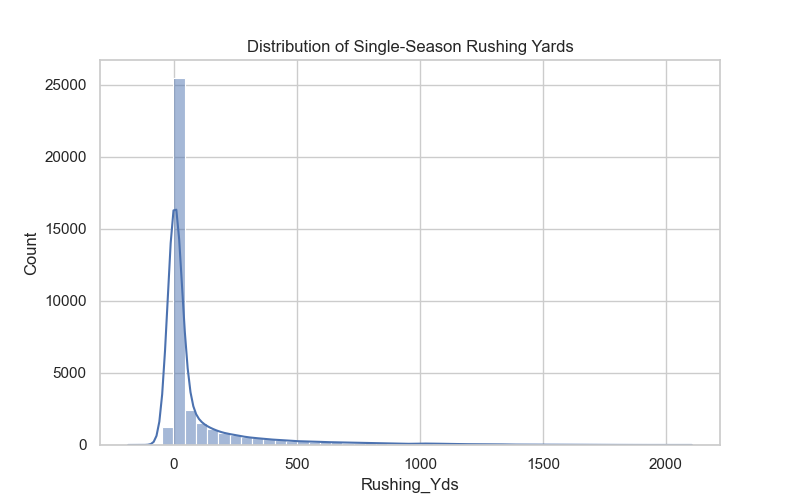

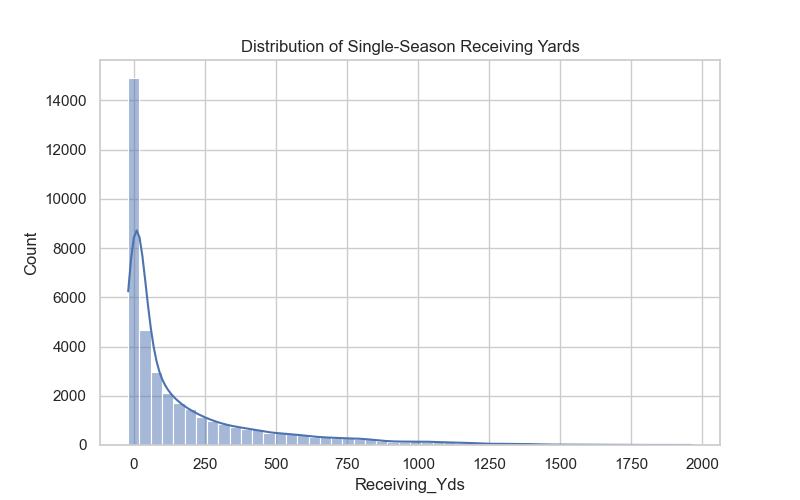

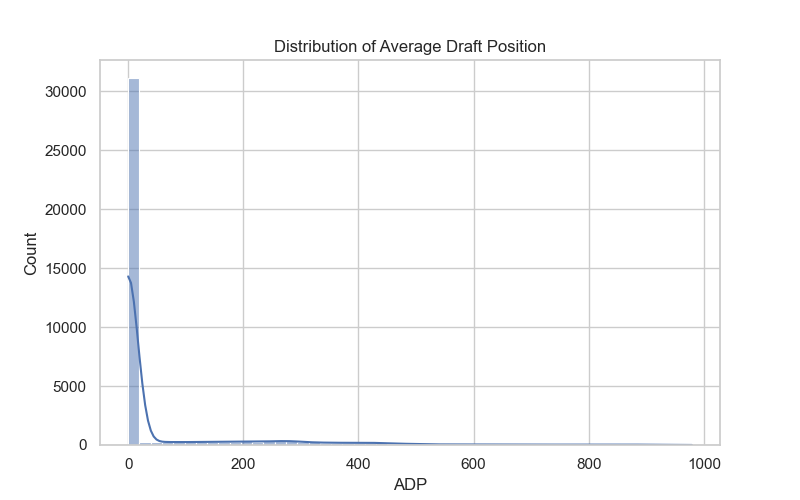

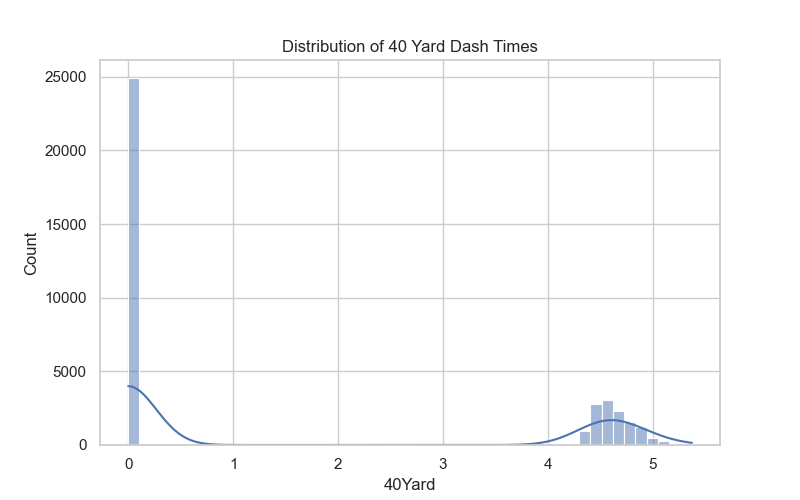

As expected, these histograms indicate that for these features, a huge number of the observations are either 0 or missing data. For passing, rushing, and receiving statistics, that is because different positions accumulate different statistics. For ADP and Scouting Combine data, it is generally because that data only goes back to 2012 and 1987, respectively.

I considered several different ways to handle these issues. For passing, rushing, and receiving statistics, the solutions was relatively simple: I decided to split my dataset by position and only include in my model the statistics that are commonly accumulated for a given position (passing and rushing for quarterbacks and rushing and receiving for running backs, wide receivers, and tight ends).

Figuring out how to handle the variance in data cutoff dates was more difficult. The simplest approach would have been to just do nothing and use all of the data as is. The models I planned to use should be robust to NaNs, so this would have allowed me to use each of my tens of thousands of observations without much extra work. However, I was particularly interested in the predictive value of ADP and scouting combine data, so I wasn't crazy about using data where the vast majority of observations have nil values for those features.

On the other extreme, I considered only including seasons from 2012 onward. This would have ensured that almost all of my observations had data for both ADP and Scouting Combine measurements. However, it would have only left me with about 6000 observations out of my initial 37000+.

As a compromise, I decided to include data from 1987 onward. This allowed me to ensure that most of my observations would have scouting combine data and a good amount would also have ADP data without throwing away too many of my observations.

Another issue with my data as it was formatted at this point was that each row contained a player's statistics for the given season, as well as their fantasy points scored for that season. However, what I actually care about for purposes of predicting fantasy points scored in a given season are the player's statistics from the prior season. Consequently, I needed to come up with a way to add each player's stats from the previous season as additional columns. If they did not have stats from the previous season, I decided to default to 0 rather than NaN because in this situation I consider 0 values to be meaningful; if a player did not play in the NFL in the previous season because they were a rookie, were injured, or for some other reason, I wanted my model to take that into account.

So, my next step was to write some code to create separate datasets for each position, limited to seasons from 1987 onward, and including the previous season's stats as additional features.

In [ ]:
# Read in the main dataframe again because in the version I read in above, I replaced some
# NaN values with 0s for the purpose of creating the histograms, but I would like them to 
# be NaNs when fed into my models.
MAIN_DF = pd.read_csv(
        'combine_data/leviathan_plus_combine.csv',
        dtype={'Season': 'int64', 
               'Pos': 'string'}
        )


def create_positional_df(pos):
    """Create new dataframe with players at the specified position in the main dataframe.

    Args:
        pos: A string that is either 'QB', 'RB', 'WR', or 'TE'.
    
    Returns:
        Null. Saves a new data frame with all player seasons from and after 1987 for the
        specified position.
    """
    pos_df = MAIN_DF.loc[
        (MAIN_DF['Pos'] == pos) &     
        (MAIN_DF['Season'] >= 1987)    
    ].copy()
    # When shifting previous season data, don't shift columns that are unchanged from season
    # to season.
    cols_to_exclude = [
        'Player', 'Season', 'Team', 'Pos', 'College', 'first_season_year', 'Draft_Class', 
        'Height(in)', 'Weight(lbs)', 'Hand Size(in)', 'Arm Length(in)', 'Wonderlic', 
        '40Yard', 'Bench Press', 'Vert Leap(in)', 'Broad Jump(in)', 'Shuttle', '3Cone'
    ]

    stat_cols = pos_df.columns.difference(cols_to_exclude)
    # Copy the stat columns from the original df and increment season number so these rows
    # can be joined as new columns to the season following the season in which the stats were
    # accumulated.
    prev_df = (
        pos_df[['Player', 'Season', 'Team', *stat_cols]]
        .copy()
        .assign(Season=lambda d: d['Season'] + 1)        
        .rename(columns={c: f'{c}_prev' for c in stat_cols})
    )

    join_keys = ['Player', 'Season', 'Team']
    # When I first wrote and ran this code, I was getting some errors indicating some 
    # duplicate entries, so I included the below code to find those.
    dup_left = (
        pos_df[pos_df.duplicated(subset=join_keys, keep=False)]
        .sort_values(join_keys)
    )

    if not dup_left.empty:
        print(f'[{pos}] duplicates in CURRENT-season data:', dup_left.shape[0])
        print(
            dup_left.groupby(join_keys, as_index=False)
            .size()
            .head(10)      
            .to_string(index=False)
        )
        dup_left.to_csv(f'{pos}_dup_left.csv', index=False)

    dup_right = (
        prev_df[prev_df.duplicated(subset=join_keys, keep=False)]
        .sort_values(join_keys)
    )

    if not dup_right.empty:
        print(f'[{pos}] duplicates in PREVIOUS-season data:', dup_right.shape[0])
        print(
            dup_right.groupby(join_keys, as_index=False)
            .size()
            .head(10)
            .to_string(index=False)
        )
        dup_right.to_csv(f'{pos}_dup_right.csv', index=False)

    overlap_counts = (
        pos_df[join_keys]
        .merge(prev_df[join_keys], on=join_keys, how='inner')
        .value_counts()
    )

    if (overlap_counts > 1).any():
        print(f'[{pos}] potential one-to-many keys across sides:')
        print(overlap_counts[overlap_counts > 1].head(10).to_string())
    # Fill previous season statistics with 0's if the values are NaN because this indicates
    # that the player either was not in the league, was injured, or just did not see the field
    # for some other reason in the previous season.
    pos_df_with_prev = pos_df.merge(
        prev_df,
        on=['Player', 'Season', 'Team'],      
        how='left',                  
        validate='1:1'              
    )

    prev_cols = [f'{c}_prev' for c in stat_cols]
    pos_df_with_prev[prev_cols] = pos_df_with_prev[prev_cols].fillna(0)

    pos_df_with_prev.to_csv(f'{pos}_with_prev.csv')


positions = ['QB', 'RB', 'WR', 'TE']

for position in positions:
    create_positional_df(position)

After that, I wanted to write some code that would select the appropriate features to use in my models based on the position being analyzed. However, as I began doing that I noticed a few additional gaps in my data: nonsensical 0 values in a few of the previous season columns I added in the previous step. This was particularly an issue with respect to advanced stats like passing success percentage. For example, some players from the 80's and 90's would have a 0 value for passing success percentage even though they clearly accrued passing stats, which didn't make sense. I also noticed that some players had a 0 value for fumbles lost even though they fumbled the ball many times during the season, which is unlikely (if a player fumbles a lot, statistically it is likely that the other team will recover at least a couple of those fumbles), and some players had an age of 0.

This happened because I chose to fill NaN values with 0's in the previous season columns, which I still think was a largely sensible decision because not accumulating stats in the prior season is something meaningful that I wanted my models to account for. However, it led to a few incongruous results as described above, so I needed to also write some code to change 0 values in those particular columns to NaNs. I think this was the best way to handle because a 0 value for these features almost certainly indicates missing data, whereas a 0 value in the other features (e.g. rushing yards or receiving touchdowns) is more likely to indicate something meaningful like an injury or poor performance. With respect to fumbles lost, it is possible that a player might really have lost 0 fumbles in a season, so I hesitated to replace those particular values with NaNs, but I ultimately determined that it would be more accurate to do that than to include inaccurate 0 values.

Given that I noticed these issues as I was getting ready to create my train/test split, I decided to write a helper function that would replace these erroneous 0's with NaNs while creating my split:

In [ ]:
from sklearn.model_selection import train_test_split


def create_mask(feature, df, stat):
    """Identify rows that have a 0 value for the specified feature but nonzero value
       for passing, rushing, or receiving yards (as specified).

    Args:
        feature: String representing the feature to search for 0 values.
        df:      A Pandas dataframe containing NFL statistics.
        stat:    String that is either 'Pass', 'Rushing', or 'Receiving'. Specifies the 
                 yardage feature to examine.

    Returns:
        Boolean mask that identifies the rows of df where the feature is 0 but the specified
        yardage type is nonzero.
    """
    return ((df[feature] == 0) & (df[f'{stat}_Yds_prev'] > 0))


def fix_0_values(df):
    """Replace erroneous 0 values with NaNs in the provided dataframe.
    
    Args:
        df: A Pandas dataframe containing NFL statistics.

    Returns:
        Dataframe with 0 values replaced with NaNs in the problematic features.
    """
    # These are the advanced stats that need to be fixed. Fumbles Lost and Age are
    # addressed separately below.
    features_to_fix = {
        'Pass': ['Pass_Succ%_prev', 'Pass_1D_prev', 'QBR_prev'],
        'Rushing': ['Rushing_Succ%_prev', 'Rushing_1D_prev'],
        'Receiving': [
            'Receiving_1D_prev',  'Receiving_Ctch%_prev', 'Receiving_Succ%_prev',
            'Receiving_Tgt_prev', 'Receiving_Y/Tgt_prev'
        ]
    }

    for stat_type in features_to_fix:
        for ftr in features_to_fix[stat_type]:
            mask = create_mask(ftr, df, stat_type)
            # Locate the rows where the mask is true and replace the specified feature
            # values with 0's.
            df.loc[mask, ftr] = np.nan

    fl_mask = (
        (df['Fumbles_FL_prev'] == 0) &
        (df['Fumbles_prev'] > 0)      
    )
    df.loc[fl_mask, 'Fumbles_FL_prev'] = np.nan

    age_mask = ((df['Age_prev'] == 0))
    df.loc[age_mask, 'Age_prev'] = np.nan

    return df


def get_train_test_split(pos):
    """Create train/test split for the specified position.

    Args:
        pos: A string that is either 'QB', 'RB', 'WR', or 'TE' (case insensitive).

    Returns:
        Training and test datasets for the specified position.
    """
    pos_lowercase = pos.lower()
    df = pd.read_csv(f'{pos_lowercase}_with_prev.csv')
    df = fix_0_values(df)

    features = []
    # These are the features that I want my model to include regardless of the position.
    base_features = [
        'Age',              'ADP',              'Height(in)',         'Weight(lbs)',      
        'Hand Size(in)',    'Arm Length(in)',   'Wonderlic',          '40Yard',           
        'Bench Press',      'Vert Leap(in)',    'Broad Jump(in)',     'Shuttle',
        '3Cone',            'ADP_prev',         'Fumbles_FL_prev',    'G_prev',           
        'GS_prev',          'Fantasy_PPR_prev'
    ]
    # Additional features to include for quarterbacks.
    pass_features = [
        '4QC_prev',         'Cmp_prev',         'Cmp%_prev',          'GWD_prev',         
        'Int_prev',         'Pass_1D_prev',     'Pass_ANY/A_prev',    'Pass_AY/A_prev',     
        'Pass_Att_prev',    'Pass_Lng_prev',    'Pass_NY/A_prev',     'Pass_Succ%',       
        'Pass_TD_prev',     'Pass_TD%_prev',    'Pass_Y/A_prev',      'Pass_Y/C_prev',    
        'Pass_Y/G_prev',    'Pass_Yds_prev',    'Passing_Rk_prev',    'QBR_prev',
        'Rate_prev',        'Int%_prev',        'Sk_prev',            'Sk%_prev'
    ]
    # Additional rushing features. I am likely going to include these for all positions, but
    # listing them separately in case I want to remove them when analyzing WRs and TEs (because 
    # they are less relevant for those positions).
    rush_features = [
        'Rushing_1D_prev',  'Rushing_A/G_prev',  'Rushing_Att_prev',  'Rushing_Lng_prev', 
        'Rushing_Rk_prev',  'Rushing_Succ%_prev', 'Rushing_TD_prev',  'Rushing_Y/A_prev', 
        'Rushing_Y/G_prev', 'Rushing_Yds_prev'
    ]
    # Additional receiving features to include for every position except quarterbacks.
    receiving_features = [
        'Receiving_Y/Tgt_prev', 'Receiving_Yds_prev', 'Receiving_Y/R_prev',   'Receiving_Y/G_prev',
        'Receiving_Tgt_prev',   'Receiving_TD_prev',  'Receiving_Succ%_prev', 'Receiving_Rk_prev',
        'Receiving_Rec_prev',   'Receiving_R/G_prev', 'Receiving_Lng_prev',
        'Receiving_Ctch%_prev', 'Receiving_1D_prev'
    ]

    if pos == 'QB':
        features = base_features + pass_features + rush_features
    else:
        features = base_features + rush_features + receiving_features

    X = df[features]
    # If a player scored 0 fantasy points in a season, I want that to be reflected in my model rather
    # than ignored as a NaN value.
    y = df['Fantasy_PPR'].fillna(0)
    # Set random_state to 42 so the split is reproducible.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.20,        
        random_state = 42,       
    )

    return X_train, X_test, y_train, y_test

As a final step before implementing my model, I wanted to create and analyze correlation matrices for each position:

In [ ]:
import numpy as np


def get_corr_matrix(pos, df):
    """Create a correlation matrix for the specified position.
    
    Args:
        pos: A string equal to 'QB', 'RB', 'WR', 'TE'.
        df: A pandas dataframe of the training data for the specified position.

    Returns:
        Null. Generates a correlation matrix from the dataframe.
    """
    corr_matrix = df.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(9, 7), dpi=150)
    # Hide the upper triangle to reduce clutter.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(
        corr_matrix,
        cmap='vlag',
        mask=mask,
        center=0,
        annot=True,
        fmt='.2f',
        annot_kws={'size': 4},      
        ax=ax
    )

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=4, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)
    plt.title(f'{pos} Correlation Matrix')
    plt.tight_layout()
    plt.show()


for pos in positions:
    X_train, X_test, y_train, y_test = get_train_test_split(pos)
    get_corr_matrix(pos, X_train)

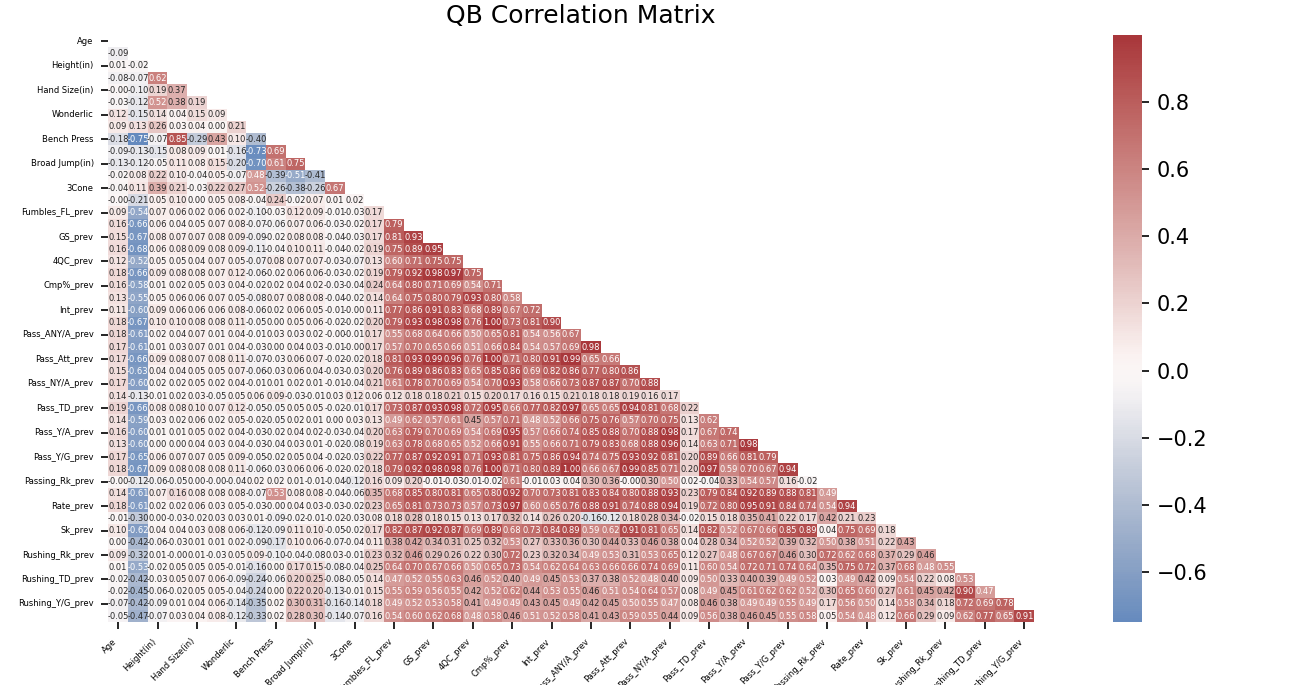
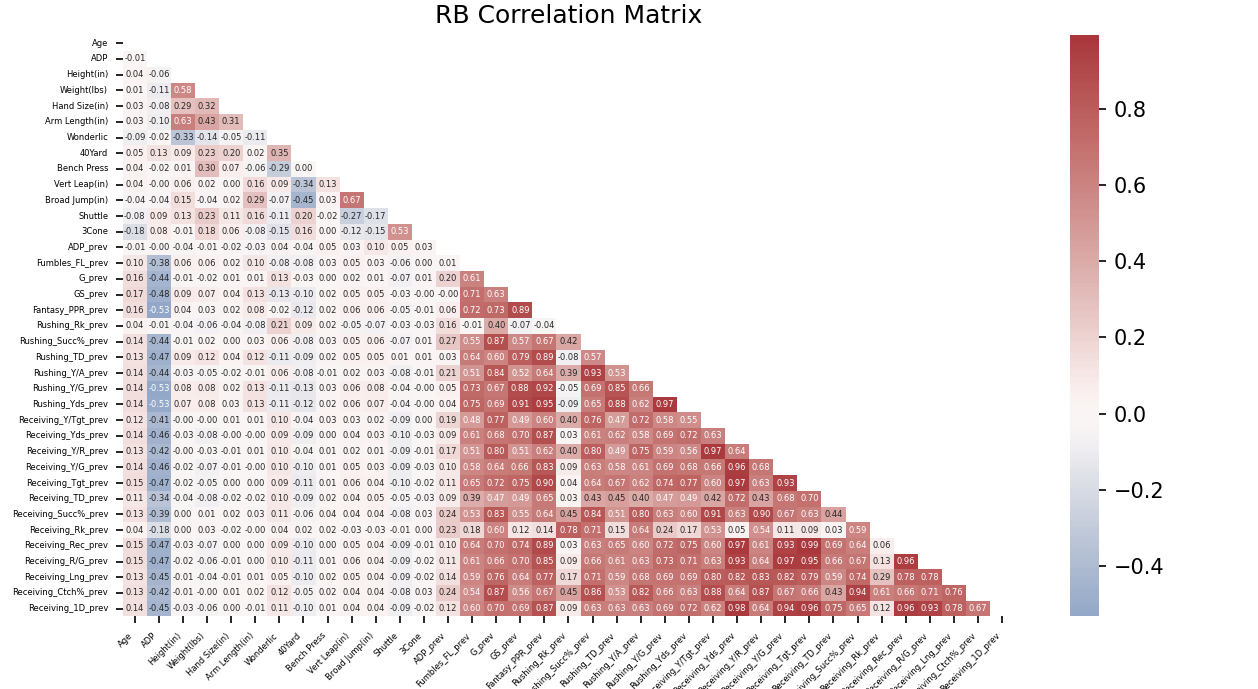
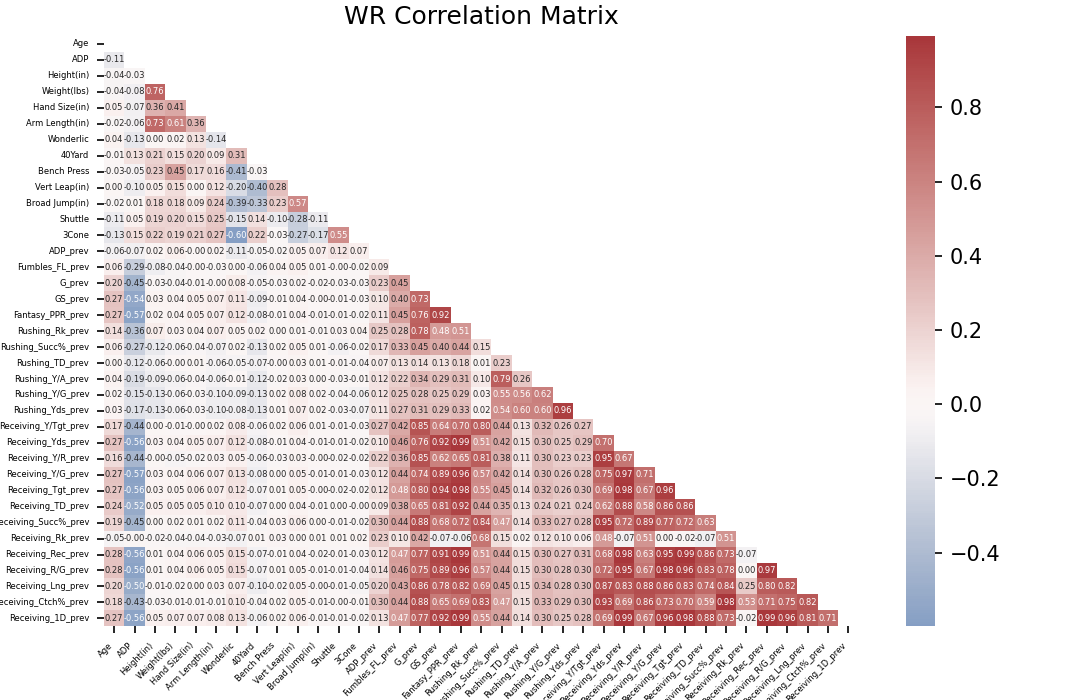
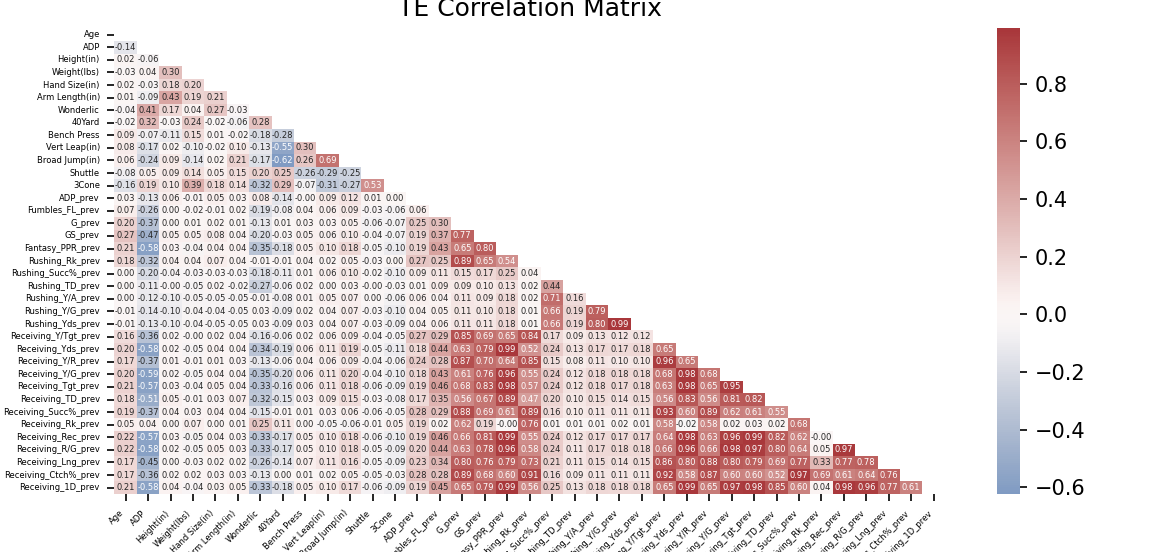

These heatmaps showed a significant amount of multicollinearity among features within the same statistical category. This didn't really surprise me as it is to be expected that, for example, the more passes a player catches the more receiving yards they will have and the more receiving touchdowns they will score. I did give some consideration to paring down some of the statistical categories that are particularly highly correlated with one another. However, because I was planning to use Random Forest and XGBoost models and they are generally robust to multicollinearity, I ultimately decided not to remove any features.

Another thing the heatmaps brought to my attention was the inverse relationship between some of the features. For a few of my features, most notably Average Draft Position and 40 yard dash time, a lower value is considered "better", which is in contrast to the majority of my features where higher values are better. This is particularly visible in the ADP column above, where there are several blue cells indicating a moderately high negative correlation between the previous year's statistics and the current season's ADP. This is a little misleading because in reality, having higher statistics the year prior is correlated with having a better ADP. I considered multiplying these "lower is better" features by -1 to reverse the direction of correlation, but after reviewing and confirming that keeping these features as they were would not cause significant issues with the interpetability of my model results or the importances, I decided not to change these features.

# EDA Conclusions and Considerations Going Forward

After thoroughly cleaning and exploring my data, I felt confident that I had a robust dataset for each position, formatted in a way that would be informative and interpretable. While I ended up not using statistics from a lot of the older seasons I pulled, feel like this was the best approach for handling some sparse features and creating datasets that had sufficient observations but that did not sacrifice accuracy and interpretability for size. I also think that because I decided to only include more recent seasons, my models may ultimately end up having more predictive value because the results will not be muddied by including seasons that were contested under older, less pass-friendly rules that may have skewed performance in a way that is not indicative of modern NFL performance.

One negative with respect to the way I set up my data is that because of the multicollinearity among statistical features, the interpretability of my models' importances will be diminished. I ultimately decided this drawback was not significant enough to warrant removing some of the correlated features because, as I noted above, it shouldn't affect the actual performance of my models. However, I will need to keep it in mind when reviewing the importance scores of my features.

# Implementing My Models: Random Forest

I knew at the outset that I wanted to run a Grid Search with a number of different values for each hyperparameter of my Random Forest model. However, I was unsure of the most appropriate values to test for the n_estimators hyperparameter, so to begin with, I built a basic Random Forest model using my QB dataset and tested it with 10 different values for n_estimators, from 100 to 1000. I felt this would give me a general idea of what numbers of estimators work best, and from there I would include 3 or 4 different values for n_estimators in my Grid Search.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score   

X_train_qb, X_test_qb, y_train_qb, y_test_qb = get_train_test_split('QB')

mean_absolute_errors = []
r2s = []
estimator_values = range(100, 1001, 100)

for i in estimator_values:
    rf = RandomForestRegressor(
        n_estimators = i,           
        random_state = 42,
    )

    rf.fit(X_train_qb, y_train_qb)

    y_pred_qb = rf.predict(X_test_qb)

    mean_absolute_errors.append(mean_absolute_error(y_test_qb, y_pred_qb))
    r2s.append(r2_score(y_test_qb, y_pred_qb))
    print(f'Finished scoring with n_estimators = {i}')

plt.figure(figsize=(6, 4))
plt.plot(estimator_values, r2s, marker='o')
plt.title('R^2 Scores')
plt.xlabel('Number of Estimators')              
plt.ylabel('R^2')  
plt.figure(figsize=(6, 4))
plt.plot(estimator_values, mean_absolute_errors, marker='o')
plt.xlabel('Number of Estimators')              
plt.ylabel('MAE')
plt.title('Mean Absolute Errors')               
plt.show()

I used Mean Absolute Error rather than Mean Squared Error primarily for interpretability. I liked that Mean Absolute Error would give me the ability to say "this model is off by +/- X points on average". Also, because I didn't change any of the default parameters of the model other than the number of estimators and the random state, I was already using MSE in the training phase, so using MAE in the testing phase seemed like it would provide good balance. This produced the following plots:

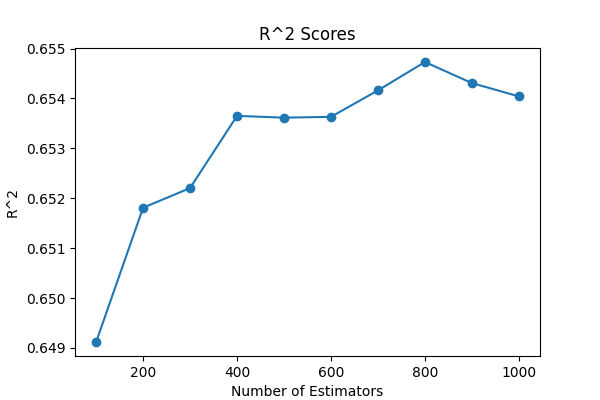
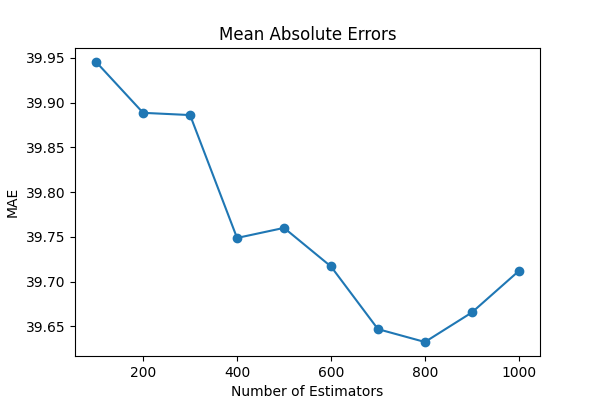

It looks like there is a large, consistent improvement up to about 400 estimators, then another more modest improvement beginning at 500-600 estimators, with performance maxing out at 800 estimators before regressing a bit at 900 and 1000 estimators.

Based on this performance, I decided to test 400, 800, and 1200 estimators as part of my Grid Search (1200 because I wanted to make sure that the model didn't reverse course and start improving again once if > 1000 estimators were used).

While I only performed this inital test on the QB dataset, I felt like I could safely assume that it would generalize relatively well to the other positional datasets, so I resolved to use those estimator values for all positions.

With that decided, I wrote my function for implementing my Grid Search:

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer


def get_best_rf(X_train, X_test, y_train, y_test):
    """Perform a Random Forest Grid Search using the provided data.
    
    Args:
        X_train: Dataframe of training observations for independent variables.
        X_test: Dataframe of test observations for independent variables.
        y_train: Dataframe of training observations for dependent variable.
        y_test: Dataframe of test observations for dependent variable.

    Returns:
        Null. Runs GridSearchCV on a base RandomForestRegressor using the provided data
        and prints the best MAE and best parameters, then uses those parameters to create
        and run a Best Estimator and prints the OOB Score, test MAE, and test R² score for
        the Best Estimator.
    """
    # I need to use TimeSeriesSplit to perform cross validation rather than just doing standard
    # cross validation because my data is time-ordered and I don't want my model to use future 
    # data to predict past events.
    tscv = TimeSeriesSplit(n_splits=5)

    param_grid = {
        'n_estimators':      [400, 800, 1200],
        # Although I used squared_error for training my initial model above, given that I'm testing
        # different parameters I want to test both criteria here as well.
        'criterion':         ['squared_error', 'absolute_error'],
        'max_depth':         [None, 8, 12, 16, 20],
        'min_samples_leaf':  [1, 2, 4, 8],
        'max_features':      [1.0, 'sqrt', 'log2'],
        'min_samples_split': [2, 4, 8, 12]
    }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    rf_base = RandomForestRegressor(
        random_state=42,
        n_jobs=-1,        
        bootstrap=True,
        oob_score=True,   
    )

    grid = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        scoring=mae_scorer,   
        cv=tscv,              
        n_jobs=-1,            
        verbose=2
    )

    grid.fit(X_train, y_train)

    print('Best MAE (CV):', -grid.best_score_)      
    print('Best params :')
    for k, v in grid.best_params_.items():
        print(f'  {k}: {v}')

    best_rf = grid.best_estimator_
    print('OOB R² :', best_rf.oob_score_)  

    y_pred = best_rf.predict(X_test)
    print('Test MAE:', mean_absolute_error(y_test, y_pred))
    print('Test R² :', r2_score(y_test, y_pred))

    importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)\
                .sort_values(ascending=False)
    print(importances.head(10))

As noted in my code comment above, because my data is time-ordered, I couldn't use standard cross validation. Instead, I had to use TimeSeriesCV to create my splits, because using standard cross validation would have just randomly shuffled the data and essentially would have allowed my model to "peek" into the future. With this function defined, I can now run my model on each position:

In [ ]:
for pos in positions:
    X_train, X_test, y_train, y_test = get_train_test_split(position_to_test)
    get_best_rf(X_train, X_test, y_train, y_test)

Note that in my results below, I didn't include the feature importances. For clarity, I separated those out for each model and have included them in their own section below.

# Random Forest Results for Quarterbacks:

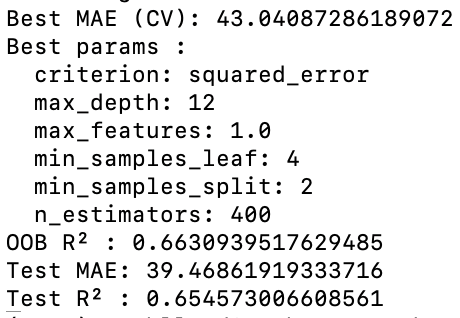

# Random Forest Results for Running Backs:

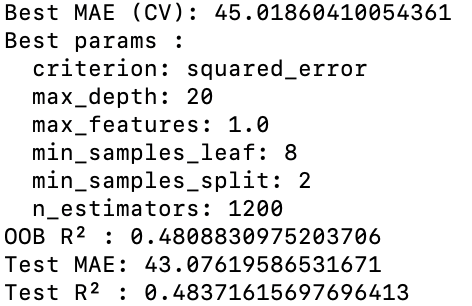

# Random Forest Results for Wide Receivers:

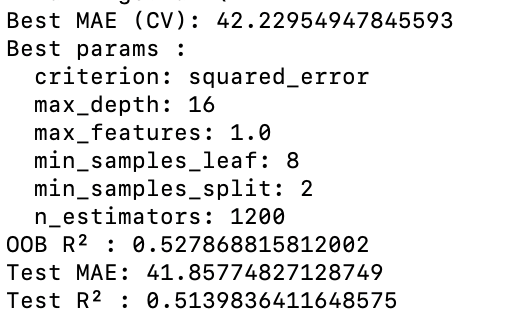

# Random Forest Results for Tight Ends:

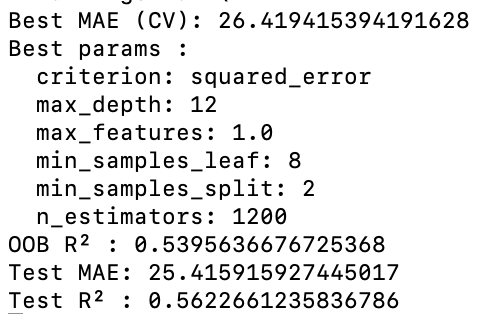

Interestingly, it looks like QB is the outlier position with respect to Test R^2, as its score is nearly 10 points higher than the second highest (TE), while the distance between the other three positions is only 8 points total. On the other hand, the MAE for TEs is much better than for the other positions. In fantasy football, tight end is notorious for being a top-heavy position: each season, the points scored by the top 2-4 TEs is comparable to the points scored by a top WR or RB, but there is a significantly steeper dropoff after the top 5 TEs compared to the other positions. It's possible that the model's superior MAE with respect to TEs is just due to the fact that TEs tend to score less points than the other positions.

# Implementing My Models: XGBoost

After implementing my Random Forest Regressor and testing out some different hyperparameters, I wanted to try out another regression model and see how it compared. I spoke with Tom during office hours, and he indicated that XGBoost has been gaining popularity in the industry and, similar to Random Forests, it is robust to sparse features, so it seemed like a good fit for my comparison model. XGBoost is an implementation is a more modern implementation of gradient boosting with a particularly strong focus on speed. Because of this, I felt like it would also offer me the opportunity for more hyperparameter tuning than my Random Forest model. I wrote the following code to implement my XGBoost model and run a Grid Search, based heavily off of my previous function implementing and Grid Searching my Random Forest model:

In [ ]:
from xgboost import XGBRegressor 


def get_best_xgb(X_train, X_test, y_train, y_test):
    """Perform an XGBoost Grid Search using the provided data.
    
    Args:
        X_train: Dataframe of training observations for independent variables.
        X_test: Dataframe of test observations for independent variables.
        y_train: Dataframe of training observations for dependent variable.
        y_test: Dataframe of test observations for dependent variable.

    Returns:
        Null. Runs GridSearchCV on a base XGBRegressor using the provided data and 
        prints the best MAE and best parameters, then uses those parameters to create
        and run a Best Estimator and prints the OOB Score, test MAE, and test R² score for
        the Best Estimator.
    """
    tscv = TimeSeriesSplit(n_splits=5)

    param_grid = {
        'n_estimators':      [400, 800, 1200],   
        'learning_rate':     [0.1, 0.05, 0.02], 
        'max_depth':         [4, 6, 8],         
        'subsample':         [0.7, 0.9, 1.0],   
        'colsample_bytree':  [0.7, 0.9, 1.0],   
        'gamma':             [0, 1, 5],         
        'min_child_weight':  [1, 5, 10],        
        'reg_lambda':        [0.0, 1.0, 5.0],   
    }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    xgb_base = XGBRegressor(
        objective='reg:absoluteerror',     
        tree_method='hist', # This setting improves the model's speed.            
        random_state=42,
        n_jobs=-1,
    )

    grid = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring=mae_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
    )

    grid.fit(X_train, y_train)

    print('Best MAE (CV):', -grid.best_score_)
    print('Best params :')
    for k, v in grid.best_params_.items():
        print(f'  {k}: {v}')

    best_xgb = grid.best_estimator_

    y_pred = best_xgb.predict(X_test)
    print('Test MAE:', mean_absolute_error(y_test, y_pred))
    print('Test R² :', r2_score(y_test, y_pred))

    importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)\
                .sort_values(ascending=False)
    print(importances.head(10))

As mentioned above, the speed of XGBoost opens up the possibility for me to experiment with a wider variety of hyperparameter values. However, it also offers significantly more hyperparameters to choose from, many of which I am not incredibly familiar with, so I asked ChatGPT o3 to recommend some hyperparameter values to test (but sticking with 400, 800, and 1200 estimators to be consistent with what I used for my Random Forest Grid Search). I did not, however, use the same values for max_depth, because the XGBRegressor documentation states that it can be extremely resource intensive when training deeper trees.

In [ ]:
for pos in positions:
    X_train, X_test, y_train, y_test = get_train_test_split(position_to_test)
    get_best_rf(X_train, X_test, y_train, y_test)

# XGBoost Results for Quarterbacks:

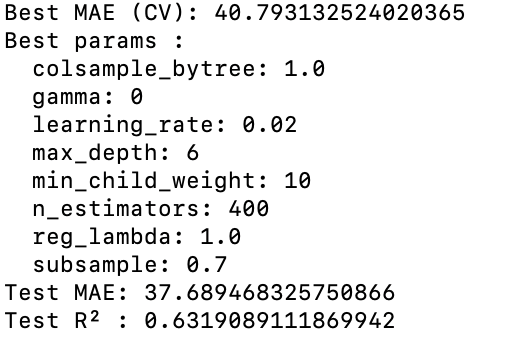

# XGBoost Results for Running Backs:

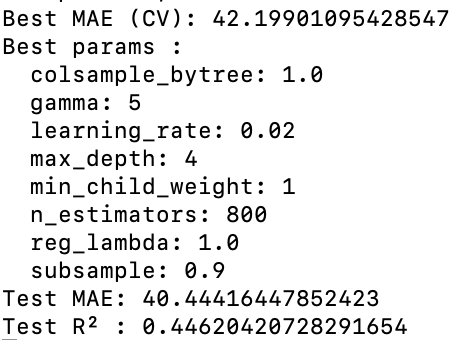

# XGBoost Results for Wide Receivers

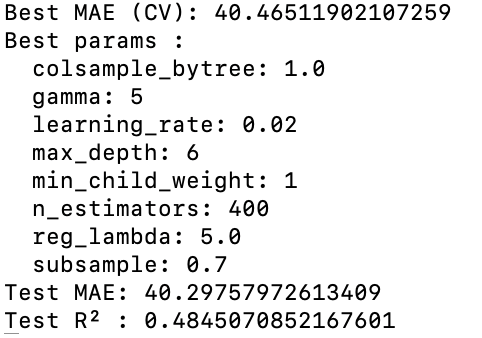

# XGBoost Results for Tight Ends

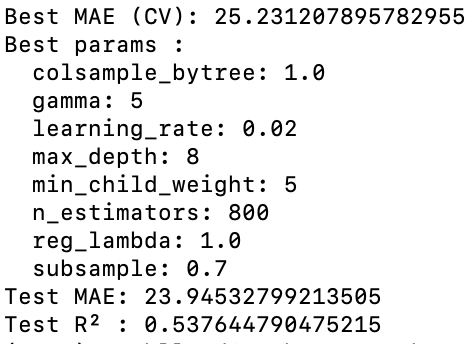

I'll have a bit more to say about this in my Results and Analysis section below, but overall it looks like the XGBoost model slightly outperformed the Random Forest model with respect to each position. On the other hand, the R^2 scores were generally lower for XGBoost than for the Random Forest, which was interesting.

# Feature Importance

The top 10 most important features for each position and each model were as follows:

Random Forest: Top 10 QB Features

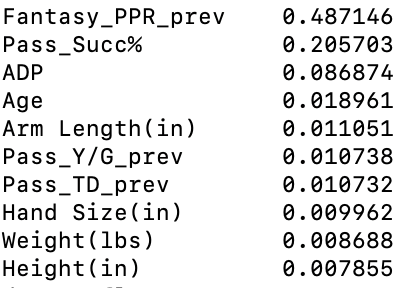

Random Forest: Top 10 RB Features

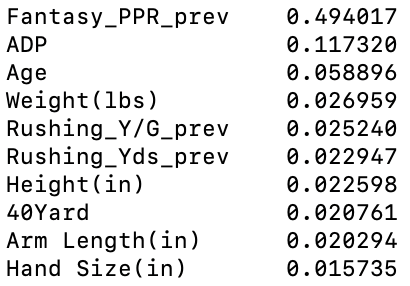

Random Forest: Top 10 WR Features

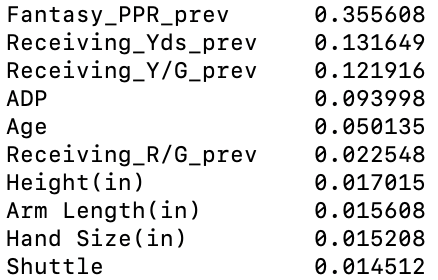

Random Forest: Top 10 TE Features

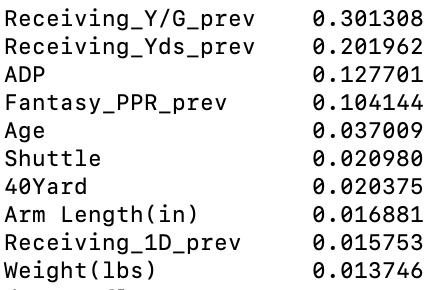

XGBoost: Top 10 QB Features

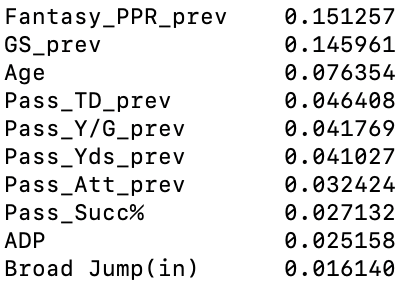

XGBoost: Top 10 RB Features

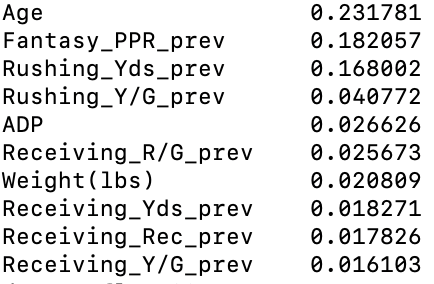

XGBoost: Top 10 WR Features

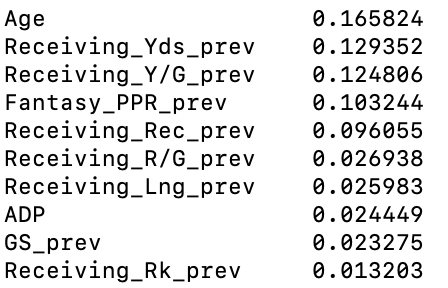

XGBoost: Top 10 TE Features

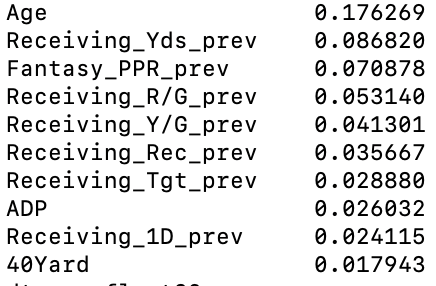

Interestingly, the importances of the models look pretty different from each other, even though the overall performance of the models seems to be fairly similar. Based on my (admittedly beginner) understanding of the models, this is likely due to the fact that they measure importance in different ways. The Random Forest uses mean-decreased impurity, whereas the default setting for XGBoost importances simply measures how many times a feature is used to split the data. There are some other settings for measuring the importances of an XGBRegressor in sklearn that I could have tried; for example, using "gain" instead of "weight" perhaps would have given me results that were more similar to the Random Forest regressors. However, I will leave that for a future project.

I also have to take these importance results with a grain of salt because of the multicollinearity that I previously identified in my data. While that multicollinearity should not have had much of an effect on model performance, it may have diluted the importance of the previous year statistical features. It is possible that those features were even more important to my models than this analysis shows.

# Comparison to Baseline

For my final step, I wanted to compare my models to a baseline, to see if they actually added any signal at all or were just noise. For fantasy football, a convenient baseline is to just use Average Draft Position. This metric represents a kind of "hive mind" value for a player based on how early the fantasy football community is drafting him in a given season, so if my models outperformed models that used only that feature, in a sense they have outperformed the fantasy football community and are likely providing some value that we couldn't get from just looking at how other fantasy football players' collective rankings.

So, I wrote a slightly modified version of my get_train_test_split function that just used the 'ADP' feature as the independent variable and reran my models using that data.

In [ ]:
def get_baseline_split(pos):
    """Create train/test split using ADP as the only independent
       variable.

    Args:
        pos: A string equal to 'QB', 'RB', 'WR', or 'TE' (case insensitve)
             representing the position of the players in the relevant dataset.

    Returns:
        Training and test datasets for the specified position containing ADP
        as the only independent variable.
    """
    pos_lowercase = pos.lower()
    df = pd.read_csv(f'{pos}_with_prev.csv')
    df = fix_0_values(df)
    # Use nested brackets to avoid a shape error when running the Random
    # Forest model (not needed for XGBoost model because it handles reshaping
    # internally, but probably good to have nonetheless).
    X = df[['ADP']]
    y = df['Fantasy_PPR'].fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.20,        
        random_state = 42,       
    )

    return X_train, X_test, y_train, y_test

This produced the following results:

Random Forest Baseline: QBs

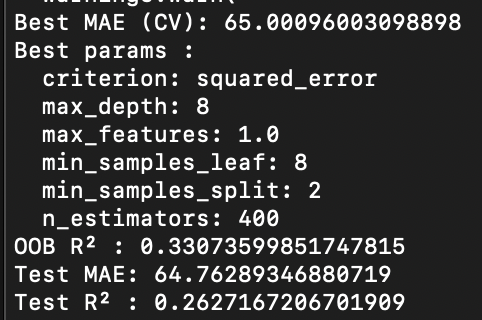

Random Forest Baseline: RBs

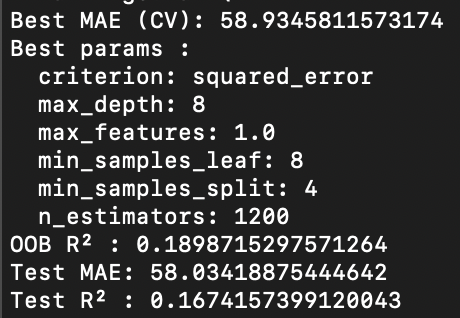

Random Forest Baseline: WRs

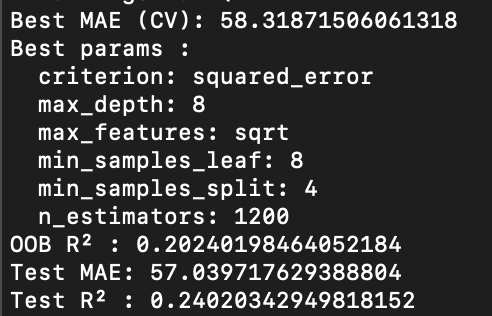

Random Forest Baseline: TEs

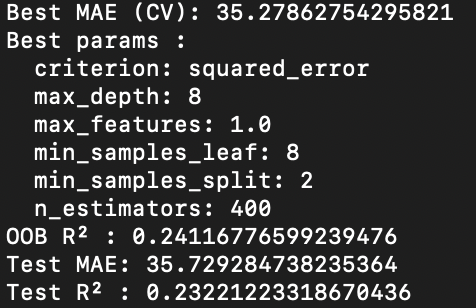

XGBoost Baseline: QBs

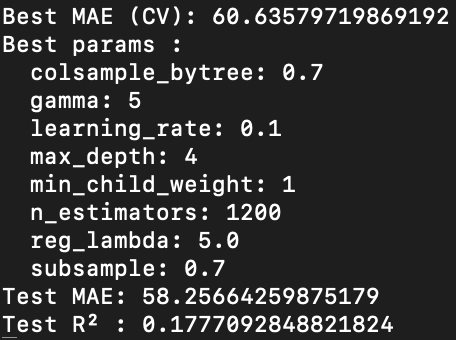

XGBoost Baseline: RBs

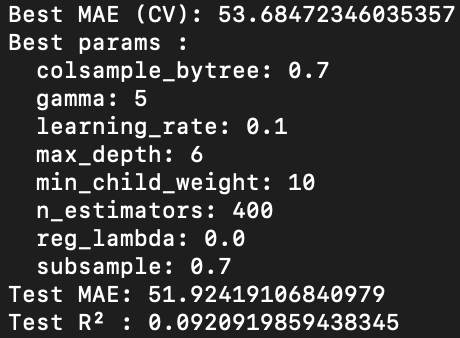

XGBoost Baseline: WRs

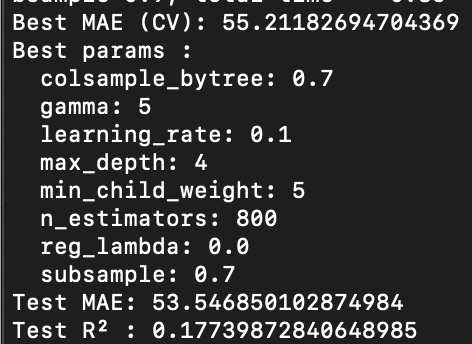

XGBoost Baseline: TEs

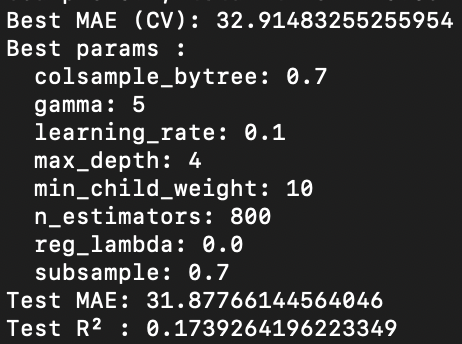

# Results and Analysis

The following two plots show how my models performed compared to each other and compared to their baselines with respect to Test MAE and R^2 Score:

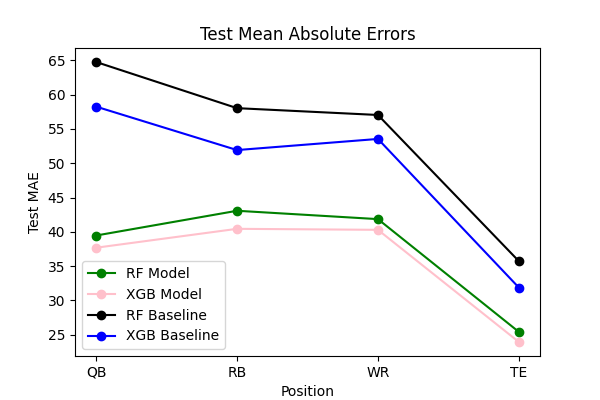
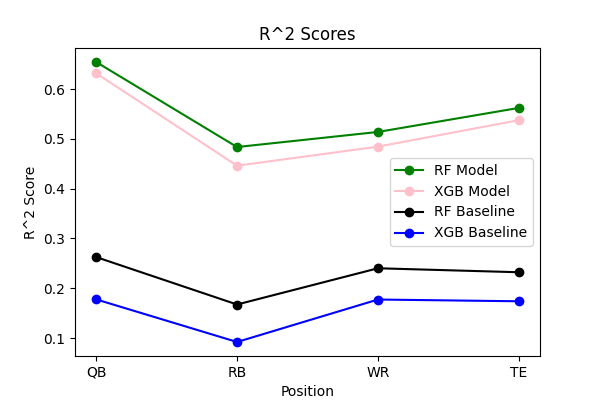

The really exciting takeaway from these charts is that both of my models outperformed both baselines by a noticeable amount on both measures across all positions. So it seems like they may indeed be adding some signal rather than just noise! 

Compared to each other, the models performed similarly. However, XGBoost produced better test MAE across all positions while Random Forest produced higher R^2 scores across all positions. It's not immediately clear to me why this would be the case. Two advantages XGBoost seems to have over Random Forest are speed and hyperparameter variety: there were many more hyperparameters for me to experiment with when using XGBoost and its speed allowed me to include more of them in my Grid Search. This may have been responsible for XGBoost's superior test MAEs, but I'm not sure why it would in turn have lower R^2 scores. This is something that will probably become clearer to me as I do further research and learn more about how these models work.

As a fantasy football player, I was also interested in how each model's performance varied across positions. Both models were similar in that they performed much better with respect to tight ends than the other positions, performed better on quarterbacks than on running backs and wide receivers, and slightly better on running backs than wide receivers. As mentioned above, I feel like the seemingly superior performance on tight ends as compared to the other positions may be because tight ends, outside the top 3 or 4, tend to score fewer points than the other positions. That said, I think most fantasy football players intuitively feel that running backs and wide receivers are more unpredictable than quarterbacks and tight ends, and the model seems to back this up.

I discussed the importances above and I reiterate that I have to be careful with interpreting them because of multicollinearity, but I do note that based on my experience playing fantasy football, I am not that surprised by most of the features in the top 10, although there were a few that were interesting. PPR points scored in the previous season seems to be hugely important in the Random Forest model, and also ranks highly in the XGBoost model. This isn't shocking because it stands to reason that players who were good last year are likely to continue to be good players this year. However, I was a little surprised by how important it seemed to be in the Random Forest model. My perception of fantasy football is that it can be quite unpredictable and at least anecdotally, player performance seems to experience a high degree of variance year over year, yet this seems to indicate perhaps a higher degree of consistency in player performance than I realized. I was also interested to see Pass Success Percentage as one of the most important features in both models. That's a more advanced metric that I was not familiar with going into this project, but I'll definitely be paying more attention to it in my fantasy football leagues going forward.

# Discussion and Conclusion

My primary takeaway from this project is that machine learning does have something to offer us when it comes to predicting player performance. My models consistently outperformed the Average Draft Position baseline, and this has encouraged me to continue on with this project past the completion of this class to see what additional improvements I might be able to make to my models. A few possible future improvements I'm considering:

    1. Adding additional features: There were several other features that I had in mind that I simply didn't have time to add as part of this project, but that I would like to possibly add to my models in future iterations. For instance, I would love to see how adding offensive line rank, Vegas projected win totals, and/or draft capital (where the player was taken in the real NFL draft) affects my models.
    2. Adding back some of the data I removed: One of the key decisions I made was to only consider seasons from 1987 onward even though I pulled statistics from PFR going back to 1932. I second-guessed this a lot during the completion of my project, and I would be interested to see how my model performance would change if I included all that additional data.
    3. Additional hyperparameter tuning: When conducting my Grid Searches, I had to balance thoroughness with time considerations. While I was able to experiment with tuning a number of parameters, there is still much more I could do. Particularly with XGBoost, I would like to research and learn more about the available hyperparameters and experiment with some different tuning settings.

I didn't really run into anything that completely did not work, but there were a few things that did not work as well as intended, and they present further areas for future improvements: 

    1. As I've mentioned a couple of times, there is some multicollinearity in my data with respect to the statistical categories, which hampered the interpretability of my model's feature importances. It would be interesting to see how these importances would change if I removed a few of the most highly correlated features, or even tried creating a couple of interaction variables. 
    2. I also noticed that when I ran my Random Forest model, for each position I got a warning that some of my fits failed. A majority of the fits were successful and I didn't feel this was significantly affecting my model, so I didn't make much of an effort to determine the cause. However, that could have been a factor that contributed to the Random Forest model's underperformance compared to the XGBoost model.
    3. I used GridSearchCV, which performed an exhaustive search of all of the hyperparameter values I specified, but at the expense of time. Now that I have an idea of appropriate parameter ranges, it would be interesting to see if I could achieve further improvements by using RandomizedSearchCV.

I look forward to further expanding and tweaking my models and continuing to iterate on this project.
